The following is based on [this article](https://medium.com/towards-data-science/differential-equations-as-a-pytorch-neural-network-layer-7614ba6d587f) in Medium.

The deep learning revolution has brought with it a new set of tools for performing large scale optimizations over enormous datasets. In this post, we will see how you can use these tools to fit the parameters of a custom differential equation layer in pytorch.

In [1]:
from pathlib import Path
from typing import Callable, List, Optional, Tuple, Union

import pylab as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchdiffeq import odeint as odeint

# Models

The first step of our modeling process is to define the model. For differential equations this means we must choose a form for the function f(y,t;θ) and a way to represent the parameters θ. We also need to do this in a way that is compatible with pytorch.

This means we need to encode our function as a torch.nn.Module class. As you will see this is pretty easy and only requires defining two methods. Lets get started with the first of out three example models.

# van Der Pol Oscillator (VDP)

We can define a differential equation system using the torch.nn.Module class where the parameters are created using the torch.nn.Parameter declaration. This lets pytorch know that we want to accumulate gradients for those parameters. We can also include fixed parameters (parameters that we don’t want to fit) by just not wrapping them with this declaration.

The first example we will use is the classic VDP oscillator which is a nonlinear oscillator with a single parameter μ. The VDP model is used to model everything from electronic circuits to cardiac arrhythmias and circadian rhythms. We can define this system in pytorch as follows:

In [2]:
class VDP(nn.Module):
    """
    Define the Van der Pol oscillator as a PyTorch module.
    """

    def __init__(
        self,
        mu: float,  # Stiffness parameter of the VDP oscillator
    ):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.tensor(mu))  # make mu a learnable parameter

    def forward(
        self,
        t: float,  # time index
        state: torch.TensorType,  # state of the system
    ) -> torch.Tensor:  # return the derivative of the state
        """
        Define the right hand side of the VDP oscillator.
        """
        x = state[..., 0]  # first dimension (...) is the batch size
        y = state[..., 1]
        dX = self.mu * (x - 1 / 3 * x**3 - y)
        dY = 1 / self.mu * x
        # trick to make sure our return value has the same shape as the input
        dfunc = torch.zeros_like(state)
        dfunc[..., 0] = dX
        dfunc[..., 1] = dY
        return dfunc

    def __repr__(self):
        """Print the parameters of the model."""
        return f" mu: {self.mu.item()}"

You only need to define the __init__ method (init) and the forward method. I added a string method __repr__ to pretty print the parameter. The key point here is how we can translate from the differential equation to torch code in the forward method. This method needs to define the right-hand side of the differential equation.

Let’s see how we can integrate this model using the odeint method from torchdiffeq:

In [3]:
vdp_model = VDP(mu=0.5)

In [4]:
# Create a time vector, this is the time axis of the ODE
ts = torch.linspace(0, 30.0, 1000)

In [5]:
# Create a batch of initial conditions
batch_size = 30

In [6]:
# Creates some random initial conditions
initial_conditions = torch.tensor([0.01, 0.01]) + 0.2 * torch.randn((batch_size, 2))

In [7]:
initial_conditions

tensor([[-0.4315, -0.2648],
        [ 0.1734, -0.0416],
        [ 0.2296,  0.1040],
        [ 0.2157,  0.0405],
        [ 0.2648,  0.3803],
        [ 0.1809,  0.1217],
        [-0.2664, -0.0739],
        [ 0.1567,  0.0952],
        [-0.0338,  0.1655],
        [ 0.3533,  0.0949],
        [ 0.0769, -0.1450],
        [ 0.0833, -0.0018],
        [ 0.1600, -0.0868],
        [-0.2028,  0.1806],
        [ 0.0714, -0.0658],
        [-0.1917,  0.2143],
        [-0.0666, -0.4113],
        [ 0.0429, -0.0353],
        [ 0.0204, -0.2396],
        [ 0.0270,  0.1859],
        [-0.2318, -0.1214],
        [ 0.3567,  0.2271],
        [ 0.4487,  0.1738],
        [ 0.0970, -0.0366],
        [ 0.0313, -0.2671],
        [-0.0655,  0.1576],
        [ 0.1098,  0.0784],
        [ 0.2149, -0.2452],
        [ 0.2511, -0.4864],
        [ 0.1391,  0.0843]])

In [8]:
# Solve the ODE, odeint comes from torchdiffeq
sol = odeint(vdp_model, initial_conditions, ts, method="dopri5").detach().numpy()

In [9]:
sol.shape

(1000, 30, 2)

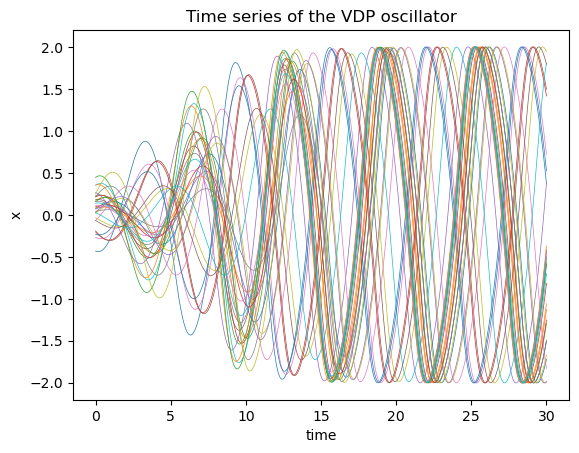

In [10]:
plt.plot(ts, sol[:, :, 0], lw=0.5)  # lw = line width
plt.title("Time series of the VDP oscillator")
plt.xlabel("time")
plt.ylabel("x");

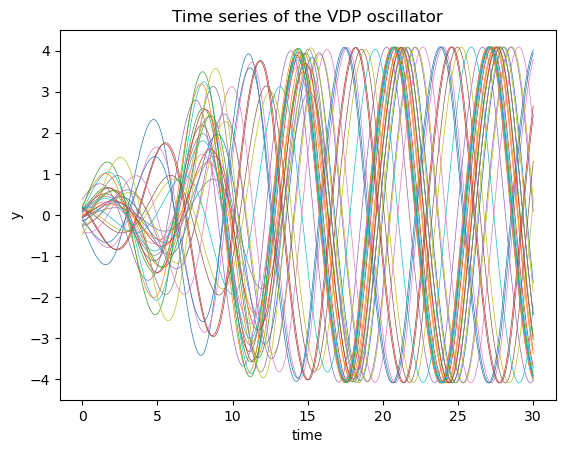

In [11]:
plt.plot(ts, sol[:, :, 1], lw=0.5)
plt.title("Time series of the VDP oscillator")
plt.xlabel("time")
plt.ylabel("y");

Here is a phase plane plot of the solution (a phase plane plot of a parametric plot of the dynamical state).

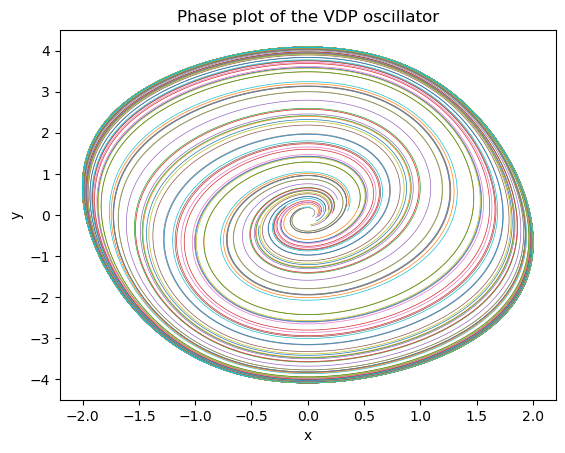

In [12]:
# Check the solution
plt.plot(sol[:, :, 0], sol[:, :, 1], lw=0.5)
plt.title("Phase plot of the VDP oscillator")
plt.xlabel("x")
plt.ylabel("y");

The colors indicate the 30 separate trajectories in our batch. The solution comes back as a torch tensor with dimensions (time_points, batch number, dynamical_dimension).

# Lotka-Volterra Predator Prey

As another example we create a module for the Lotka-Volterra predator-prey equations. In the Lotka-Volterra (LV) predator-prey model, there are two primary variables: the population of prey (x) and the population of predators (y).

In addition to the primary variables, there are also four parameters that are used to describe various ecological factors in the model:

α represents the intrinsic growth rate of the prey population in the absence of predators. β represents the predation rate of the predators on the prey. γ represents the death rate of the predator population in the absence of prey. δ represents the efficiency with which the predators convert the consumed prey into new predator biomass.

Together, these variables and parameters describe the dynamics of predator-prey interactions in an ecosystem and are used to mathematically model the changes in the populations of prey and predators over time. Here is this system as a torch.nn.Module:

In [13]:
class LotkaVolterra(nn.Module):
    """
    The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
    describing the dynamics of two species interacting in a predator-prey relationship.
    """

    def __init__(
        self,
        alpha: float = 1.5,  # The alpha parameter of the Lotka-Volterra system
        beta: float = 1.0,  # The beta parameter of the Lotka-Volterra system
        delta: float = 3.0,  # The delta parameter of the Lotka-Volterra system
        gamma: float = 1.0,  # The gamma parameter of the Lotka-Volterra system
    ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(
            torch.tensor([alpha, beta, delta, gamma])
        )

    def forward(self, t, state):
        x = state[..., 0]  # variables are part of vector array u
        y = state[..., 1]
        sol = torch.zeros_like(state)

        # coefficients are part of tensor model_params
        alpha, beta, delta, gamma = self.model_params
        sol[..., 0] = alpha * x - beta * x * y
        sol[..., 1] = -delta * y + gamma * x * y
        return sol

    def __repr__(self):
        return f" alpha: {self.model_params[0].item()}, \
            beta: {self.model_params[1].item()}, \
                delta: {self.model_params[2].item()}, \
                    gamma: {self.model_params[3].item()}"

This follows the same pattern as the first example, the main difference is that we now have four parameters and store them as a `model_params` tensor. Here is the integration and plotting code for the predator-prey equations.

In [14]:
lv_model = LotkaVolterra()  # use default parameters

In [15]:
ts = torch.linspace(0, 30.0, 1000)
batch_size = 30

In [16]:
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[3, 3]]) + 0.50 * torch.randn((batch_size, 2))

In [17]:
sol = odeint(lv_model, initial_conditions, ts, method="dopri5").detach().numpy()

In [18]:
sol.shape

(1000, 30, 2)

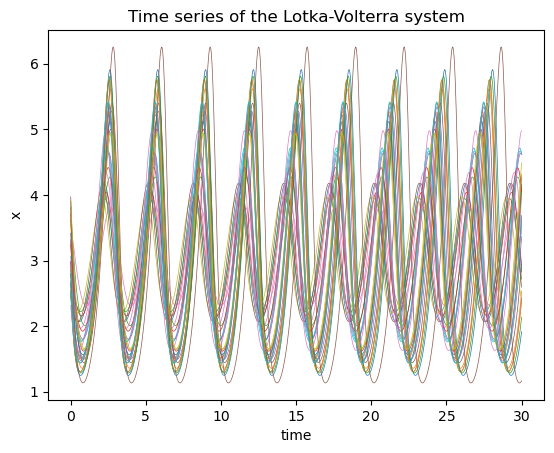

In [19]:
# Check the solution

plt.plot(ts, sol[:, :, 0], lw=0.5)
plt.title("Time series of the Lotka-Volterra system")
plt.xlabel("time")
plt.ylabel("x");

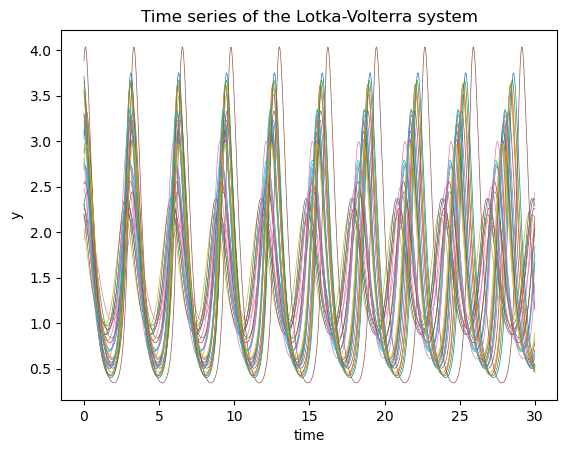

In [20]:
# Check the solution

plt.plot(ts, sol[:, :, 1], lw=0.5)
plt.title("Time series of the Lotka-Volterra system")
plt.xlabel("time")
plt.ylabel("y");

Now a phase plane plot of the system:

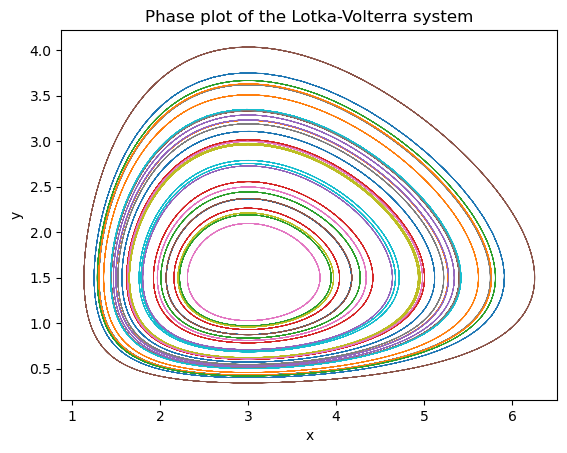

In [21]:
# Check the solution
plt.plot(sol[:, :, 0], sol[:, :, 1], lw=0.5)
plt.title("Phase plot of the Lotka-Volterra system")
plt.xlabel("x")
plt.ylabel("y");

# Lorenz system

The last example we will use is the Lorenz equations which are famous for their beautiful plots illustrating chaotic dynamics. They originally came from a reduced model for fluid dynamics.

x, y, and z are the state variables, and σ, ρ, and β are the system parameters.

In [22]:
class Lorenz(nn.Module):
    """
    Define the Lorenz system as a PyTorch module.
    """

    def __init__(
        self,
        sigma: float = 10.0,  # The sigma parameter of the Lorenz system
        rho: float = 28.0,  # The rho parameter of the Lorenz system
        beta: float = 8.0 / 3,  # The beta parameter of the Lorenz system
    ):
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([sigma, rho, beta]))

    def forward(self, t, state):
        x = state[..., 0]  # variables are part of vector array u
        y = state[..., 1]
        z = state[..., 2]
        sol = torch.zeros_like(state)

        sigma, rho, beta = self.model_params  # coefficients are part of vector array p
        sol[..., 0] = sigma * (y - x)
        sol[..., 1] = x * (rho - z) - y
        sol[..., 2] = x * y - beta * z
        return sol

    def __repr__(self):
        return f" sigma: {self.model_params[0].item()}, \
            rho: {self.model_params[1].item()}, \
                beta: {self.model_params[2].item()}"

This shows how to integrate this system and plot the results. This system (at these parameter values) shows chaotic dynamics so initial conditions that start off close together diverge from one another exponentially.

In [23]:
lorenz_model = Lorenz()

In [24]:
ts = torch.linspace(0, 50.0, 3000)

In [25]:
batch_size = 30

In [26]:
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[1.0, 0.0, 0.0]]) + 0.10 * torch.randn(
    (batch_size, 3)
)

In [27]:
sol = odeint(lorenz_model, initial_conditions, ts, method="dopri5").detach().numpy()

In [28]:
sol.shape

(3000, 30, 3)

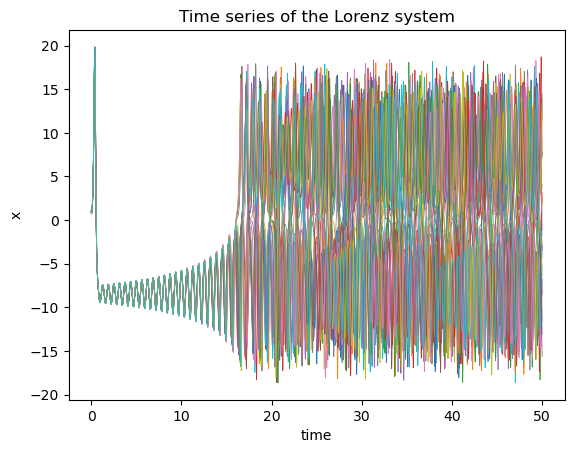

In [29]:
# Check the solution
plt.plot(ts, sol[:, :, 0], lw=0.5)
plt.title("Time series of the Lorenz system")
plt.xlabel("time")
plt.ylabel("x");

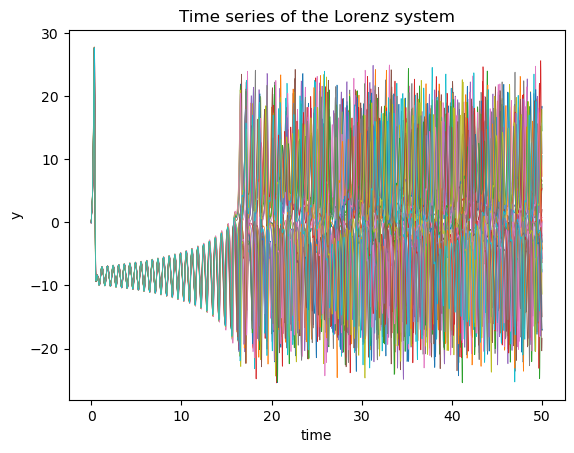

In [30]:
# Check the solution
plt.plot(ts, sol[:, :, 1], lw=0.5)
plt.title("Time series of the Lorenz system")
plt.xlabel("time")
plt.ylabel("y");

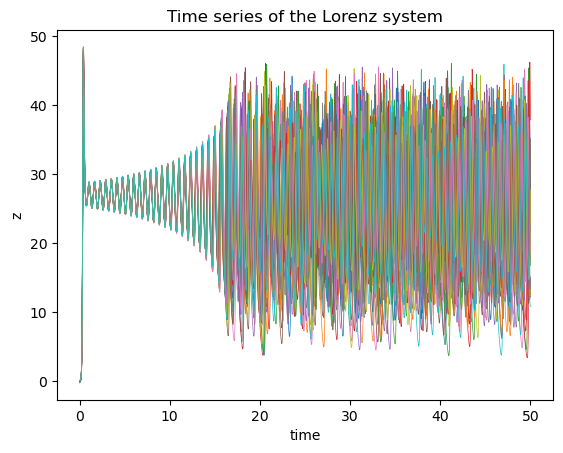

In [31]:
# Check the solution
plt.plot(ts, sol[:, :, 2], lw=0.5)
plt.title("Time series of the Lorenz system")
plt.xlabel("time")
plt.ylabel("z");

Here we show the famous butterfly plot (phase plane plot) for the first set of initial conditions in the batch.

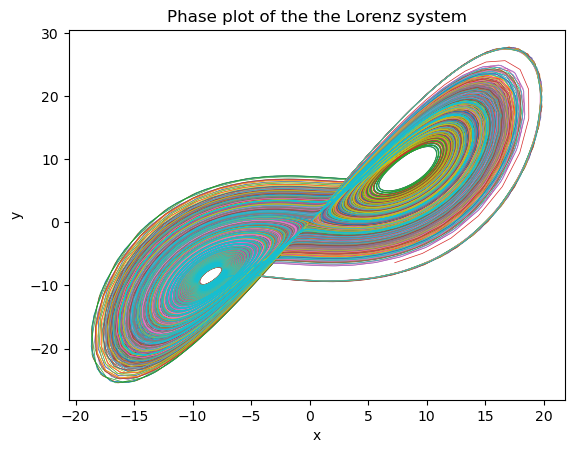

In [32]:
# Check the solution
plt.plot(sol[:, :, 0], sol[:, :, 1], lw=0.5)
plt.title("Phase plot of the the Lorenz system")
plt.xlabel("x")
plt.ylabel("y");

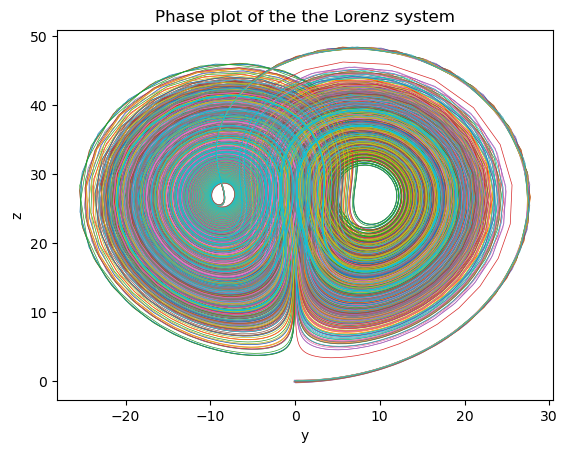

In [33]:
# Check the solution
plt.plot(sol[:, :, 1], sol[:, :, 2], lw=0.5)
plt.title("Phase plot of the the Lorenz system")
plt.xlabel("y")
plt.ylabel("z");

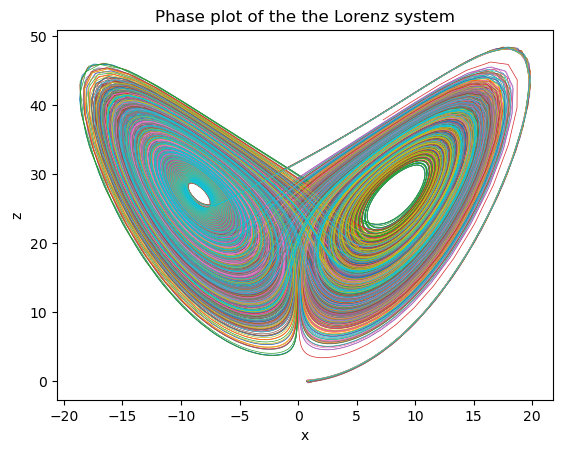

In [34]:
# Check the solution
plt.plot(sol[:, :, 0], sol[:, :, 2], lw=0.5)
plt.title("Phase plot of the the Lorenz system")
plt.xlabel("x")
plt.ylabel("z");

# Data